# Image Segmentation

In this Notebook, we will be looking at different image segmentation techniques and apply them to different data. 

This code accompanies the final report PDF in the same repository.


---


**By**
### Uljad Berdica
### Mohamed Alhossani
### Adam Wassim Ali-Hassan

In [ ]:
#basic python
import numpy as np
import matplotlib.pyplot as plt
import os

#to work with images
from google.colab.patches import cv2_imshow
import argparse
import imutils
import cv2
import pathlib
from google.colab import drive


#For the WaterShed
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

## We will import the pyTorch stuff in later cells


In [ ]:
drive.mount('/content/drive',force_remount=True)
img_folder='/content/drive/My Drive/An_IntroToML_CLASS/ClassProject_introML/Img/'

Mounted at /content/drive


(4032, 2268, 3)
(806, 453, 3)


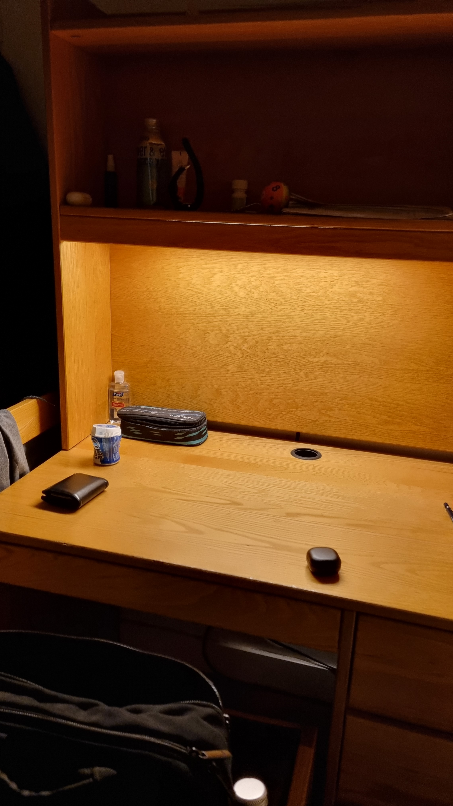

In [ ]:
img1_name="Test1.jpg"
img1=cv2.imread(os.path.join(img_folder,img1_name))
print(img1.shape)

scale_percent = 20 # percent of original size
width = int(img1.shape[1] * scale_percent / 100)
height = int(img1.shape[0] * scale_percent / 100)
dim = (width, height)

img1= cv2.resize(img1, dim)
print(img1.shape)
cv2_imshow(img1)

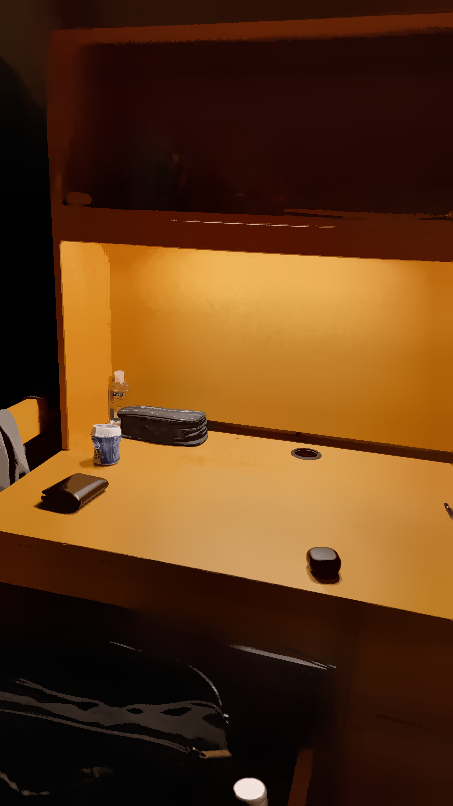

In [13]:
shifted = cv2.pyrMeanShiftFiltering(img1, 20, 31)
cv2_imshow(shifted)

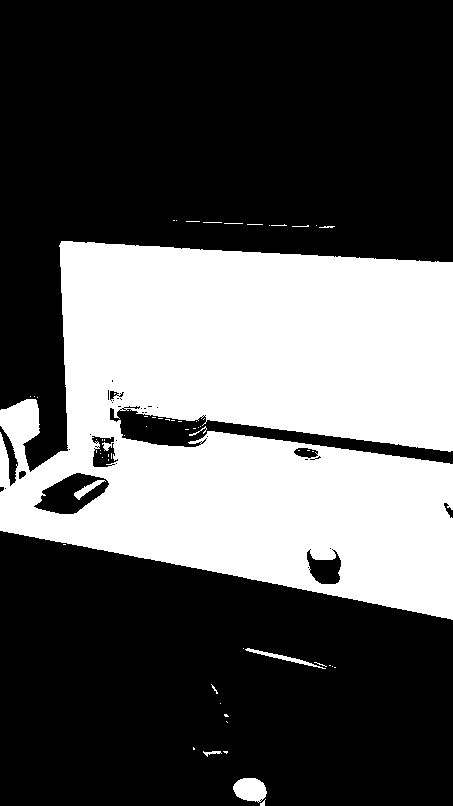

In [15]:
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

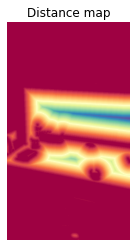

In [17]:
# For using the watershed algorithm, we need to find peaks of the topographic map.
# fisrt we need to build the distance map by computing the Euclidean Distance to the closest zero (i.e., background pixel) 
# for each of the foreground pixels.  
D = ndimage.distance_transform_edt(thresh)
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(D,cmap="Spectral")
ax.set_title('Distance map')
plt.show()

In [19]:
# perform a connected component analysis on the local peaks,
# then appy the Watershed algorithm
localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("{} unique segments found".format(len(np.unique(labels)) - 1))

23 unique segments found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


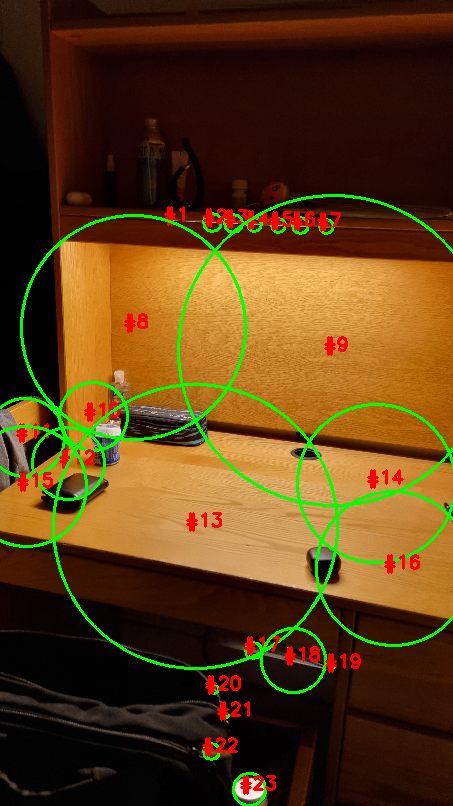

-1

In [23]:
# then we just need to assign each pixel with different labels found by watershed method
# we will loop each unique labels  
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
	# draw a circle enclosing the object which have the same labels 
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(img1, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(img1, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
cv2_imshow(img1)
cv2.waitKey(0)